# Feature-wise normalization of .nii images

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
input_dir = '../data/SPM-preprocessed/'
output_dir = '../data/SPM-preprocessed-normalized/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Utility

In [3]:
def get_nii_data_in_directory(directory):
    files = os.listdir(directory)
    for file in files:
        if file[-4:] == '.nii':
            nii_data = nib.load(directory + file)
            yield nii_data, file

In [4]:
def get_all_nii_data_in_directory(directory):
    generator = get_nii_data_in_directory(directory)
    nii_data = []
    file_names = []
    for i_nii_data, file_name in generator:
        nii_data.append(i_nii_data)
        file_names.append(file_name)
    return nii_data, file_names

In [5]:
def save_normalized_data_to_directory(nii_data, file_name, directory):
    nib.save(nii_data, directory + file_name)

In [6]:
def feature_wise_normalize(images):
    
    length = len(images)
    dim_x = images[0].shape[0]
    dim_y = images[0].shape[1]
    dim_z = images[0].shape[2]
    
    x_transformed = np.zeros((length, dim_x, dim_y, dim_z))
    
    for image_index in range(length):
        
        x_train_one = np.zeros((dim_z, dim_x, dim_y, 1))
        x_transformed_one = np.zeros((dim_z, dim_x, dim_y, 1))
        
        for slice_index in range(dim_z):
            x_train_one[slice_index, :, :, 0] = images[image_index][:, :, slice_index]    # Why?
            
        datagen_featurewise_mean = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
        datagen_featurewise_mean.fit(x_train_one)
        
        batches = 0
        count = 0
        for x_batch in datagen_featurewise_mean.flow(x_train_one, shuffle = False):
            
            for i_inb in range(x_batch.shape[0]):
                x_transformed_one[count + i_inb, :, :, :] = (x_batch[i_inb] + 3) / 12
            
            count += x_batch.shape[0]
            batches += 1
            if batches >= len(x_train_one) / 32:
                break
                
        for slice_index in range(dim_z):
            x_transformed[image_index, :, :, slice_index] = x_transformed_one[slice_index, :, :, 0]
            
    return x_transformed

#### Read, normalize, and save

In [7]:
nii_data, file_names = get_all_nii_data_in_directory(input_dir)

In [8]:
images = []
for i_nii_data in nii_data:
    images.append(i_nii_data.get_fdata())

In [9]:
normalized_images = feature_wise_normalize(images)

In [10]:
for normalized_image, i_nii_data, file_name in zip(normalized_images, nii_data, file_names):
    new_nii_data = nib.Nifti1Image(normalized_image, i_nii_data.affine, i_nii_data.header)
    save_normalized_data_to_directory(new_nii_data, file_name, output_dir)

# Plot distributions etc

In [11]:
plot_img_nr = 0

## Distribution before normalization:

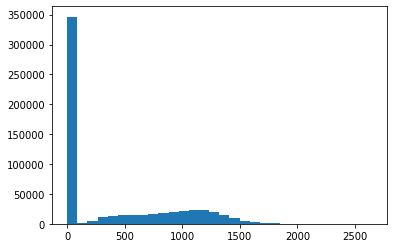

In [12]:
plt.hist(images[plot_img_nr].flatten(), bins = 30)
plt.show()

In [ ]:
plt.imshow(images[plot_img_nr][:, 30, :], cmap = 'gray')

## Distribution after normalization:

In [ ]:
plt.hist(normalized_images[plot_img_nr].flatten(), range = [0, 1], bins = 30)
plt.show()

In [ ]:
plt.imshow(normalized_images[plot_img_nr, :, 30, :], cmap = 'gray')